earth: [ -1.8021557  -27.41324792 -11.88324801] km / s
va: [ -2.04654112 -30.23377408 -12.41272408] km / s
vb: [-14.51688715  16.60861398   6.8348052 ] km / s
va: [-0.25028786, -2.82756743, -0.51287549]  Deltav: 2.884583653199006


[  1.84870204e+08   9.95802671e+07   4.06323733e+07] km
[  1.84768223e+08   9.96965225e+07   4.07490938e+07] km


<IPython.core.display.Javascript object>


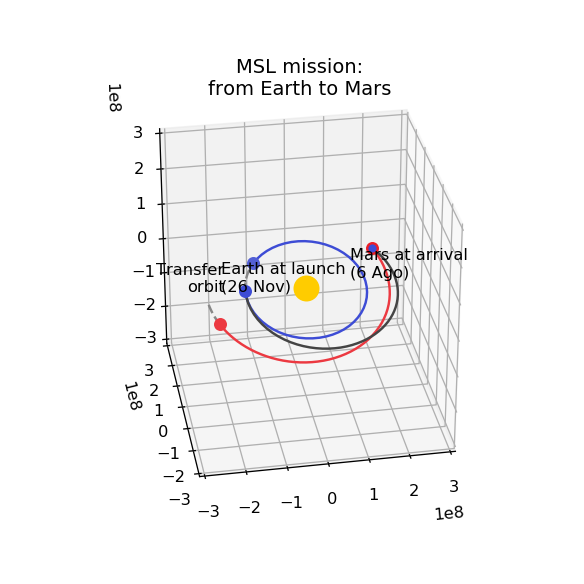

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import astropy.units as u
from astropy import time as ast_time

from poliastro import iod
from poliastro.bodies import Sun
from poliastro.twobody import Orbit

from astropy.coordinates import solar_system_ephemeris
from poliastro.ephem import get_body_ephem
from numpy import linalg as LA
#initial data
N = 50

date_launch = ast_time.Time('2031-03-18 17:53:57.459', scale='utc')
date_arrival = ast_time.Time('2032-02-11 11:41:59.911', scale='utc')

tof = (date_arrival - date_launch)

tof.to(u.h)

# Calculate vector of times from launch and arrival Julian days
dt = (date_arrival - date_launch) / N

# Idea from http://docs.astropy.org/en/stable/time/#getting-started
times_vector = date_launch + dt * np.arange(N + 1)


rr_earth, vv_earth = get_body_ephem("earth", times_vector)

rr_mars, vv_mars = get_body_ephem("mars", times_vector)


# Compute the transfer orbit!
r0 = rr_earth[:, 0]
rf = rr_mars[:, -1]

(va, vb), = iod.lambert(Sun.k, r0, rf, tof)
print('earth: {}'.format(vv_earth[:,0].to(u.km/u.s)))
print('va: {}'.format(va, LA.norm(va)))
print('vb: {}'.format(vb))
va = [-0.25028786, -2.82756743, -0.51287549]
print('va: {}  Deltav: {}'.format(va, LA.norm(va)))
va = va*(u.kilometer/u.second) + vv_earth[:,0]


ss0_trans = Orbit.from_vectors(Sun, r0, va, date_launch)
ssf_trans = Orbit.from_vectors(Sun, rf, vb, date_arrival)

#28.917838756495776, -15.162264251747075, -5.6894676852347015

rr_trans = np.zeros_like(rr_earth)
rr_trans[:, 0] = r0
for ii in range(1, len(times_vector)):
    tof = (times_vector[ii] - times_vector[0]).to(u.day)
    rr_trans[:, ii] = ss0_trans.propagate(tof).r
print(rr_trans[:,-1])
print(rf)
    
# Now compute the trail, better backwards
date_final = date_arrival - 1 * u.year
dt2 = (date_final - date_launch) / N

times_rest_vector = date_launch + dt2 * np.arange(N + 1)
rr_earth_rest, _ = get_body_ephem("earth", times_rest_vector)
rr_mars_rest, _ = get_body_ephem("mars", times_rest_vector)

#Plot figure
# To add arrows:
# https://github.com/matplotlib/matplotlib/blob/v2.0.0/lib/matplotlib/streamplot.py#L172-L191

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

def plot_body(ax, r, color, size, border=False, **kwargs):
    """Plots body in axes object.

    """
    return ax.plot(*r[:, None], marker='o', color=color, ms=size, mew=int(border), **kwargs)

# I like color
color_earth0 = '#3d4cd5'
color_earthf = '#525fd5'
color_mars0 = '#ec3941'
color_marsf = '#ec1f28'
color_sun = '#ffcc00'
color_orbit = '#888888'
color_trans = '#444444'

# Plotting orbits is easy!
ax.plot(*rr_earth.to(u.km).value, c=color_earth0)
ax.plot(*rr_mars.to(u.km).value, c=color_mars0)

ax.plot(*rr_trans.to(u.km).value, c=color_trans)

ax.plot(*rr_earth_rest.to(u.km).value, ls='--', c=color_orbit)
ax.plot(*rr_mars_rest.to(u.km).value, ls='--', c=color_orbit)

# But plotting planets feels even magical!
plot_body(ax, np.zeros(3), color_sun, 16)

plot_body(ax, r0.to(u.km).value, color_earth0, 8)
plot_body(ax, rr_earth[:, -1].to(u.km).value, color_earthf, 8)

plot_body(ax, rr_mars[:, 0].to(u.km).value, color_mars0, 8)
plot_body(ax, rf.to(u.km).value, color_marsf, 8)
plot_body(ax, rr_trans[:,-1].value, color_earth0, 5)
# Add some text
#ax.text(-0.75e8, -3.5e8, -1.5e8, "MSL mission:\nfrom Earth to Mars", size=20, ha='center', va='center', bbox={"pad": 30, "lw": 0, "fc": "w"})
ax.text(r0[0].to(u.km).value * 1.4, r0[1].to(u.km).value * 0.4, r0[2].to(u.km).value * 1.25,
        "Earth at launch\n(26 Nov)", ha="left", va="bottom")#, backgroundcolor='#ffffff')
ax.text(rf[0].to(u.km).value * 0.7, rf[1].to(u.km).value * 1.1, rf[2].to(u.km).value,
        "Mars at arrival\n(6 Ago)", ha="left", va="top")#, backgroundcolor='#ffffff')
ax.text(-1.9e8, 8e7, 0, "Transfer\norbit", ha="right", va="center")#, backgroundcolor='#ffffff')

# Tune axes
ax.set_xlim(-3e8, 3e8)
ax.set_ylim(-3e8, 3e8)
ax.set_zlim(-3e8, 3e8)

# And finally!
ax.view_init(30, 260)
ax.set_title("MSL mission:\nfrom Earth to Mars")
fig.savefig("trans_30_260.png", bbox_inches='tight')